In [1]:
%%configure -f
{
    "conf": {
        "spark.pyspark.python": "python3",
        "spark.pyspark.virtualenv.enabled": "true",
        "spark.pyspark.virtualenv.type":"native",
        "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv"
    }
}

In [2]:
sc.install_pypi_package("boto3==1.19.2")
sc.install_pypi_package("pandas==1.0.5")
sc.install_pypi_package("scipy==1.4.1")
sc.install_pypi_package("matplotlib==3.2.1")
sc.install_pypi_package("seaborn==0.10.1")

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1684199508172_0002,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import numpy as np
import matplotlib.pyplot as plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
data = spark.read.parquet('s3://amazon-reviews-pds/parquet/product_category=Books/*.parquet')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Q2

In [5]:
data = data.withColumn('good_review', (data.star_rating >= 4).cast("integer")) \
                           .persist()
data = data.withColumn('title_len', (length(data.product_title)).cast("integer")) \
                           .persist()
data = data.withColumn('helpful_prop', (data.helpful_votes / data.total_votes).cast("double")) \
                           .persist()
data = data.withColumn('verified_pur', (data.verified_purchase == "Y").cast("integer")) \
                           .persist()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
sampled = data.sampleBy("good_review", fractions={1:0.2,0:1},seed = 521)
sampled.groupBy('good_review').count().show()

# Q3

In [9]:
features = ['total_votes', "title_len", "helpful_prop", "verified_pur"]
assembler = VectorAssembler(inputCols = features, outputCol = 'features')
try:
    sampled = sampled.drop("features")
except:
    pass
sampled = assembler.transform(sampled.na.drop())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
def Train(model, train):
    if train is not None:
        model = model.fit(train)
        trainingSummary = model.summary
        print("Training AUC: " + str(trainingSummary.areaUnderROC))
        print("\nFalse positive rate by label (Training):")
        for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
            print("label %d: %s" % (i, rate))
        print("\nTrue positive rate by label (Training):")
        for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
            print("label %d: %s" % (i, rate))
        print("\nTraining Accuracy: " + str(trainingSummary.accuracy))
    return model

In [22]:
train, test = sampled.randomSplit([0.7, 0.3], seed = 521)
lr = LogisticRegression(featuresCol='features', labelCol='good_review')     
trained1 = Train(lr, train)
evaluationSummary1 = trained1.evaluate(test)
print("Test AUC: ", str(evaluationSummary1.areaUnderROC))  
print("Test Accuracy: ", str(evaluationSummary1.accuracy))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Training AUC: 0.6913424688766178

False positive rate by label (Training):
label 0: 0.4726280792931711
label 1: 0.23405795555414424

True positive rate by label (Training):
label 0: 0.7659420444458558
label 1: 0.5273719207068289

Training Accuracy: 0.6667222146548152
Test AUC:  0.6919096783293017
Test Accuracy:  0.6672860065693302

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

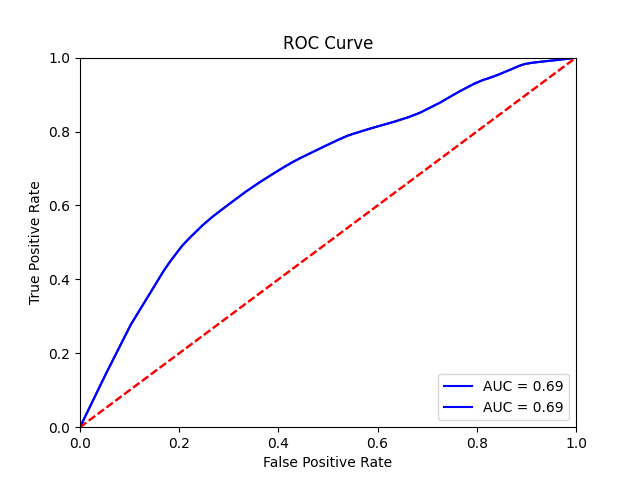

In [24]:
roc_df = evaluationSummary1.roc.toPandas()
plt.plot(roc_df.FPR, roc_df.TPR, 'b', label = 'AUC = %0.2f' % evaluationSummary1.areaUnderROC)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()
%matplot plt

# Q4

In [14]:
train_data = train.withColumnRenamed("good_review","label")
test_data = test.withColumnRenamed("good_review","label")
lr = LogisticRegression()
grid = ParamGridBuilder().addGrid(lr.regParam, np.arange(0,.1,.01)) \
.addGrid(lr.elasticNetParam, [0, 1]).build()
evaluator = BinaryClassificationEvaluator()
cv = CrossValidator(estimator=lr, estimatorParamMaps=grid, evaluator=evaluator,
    parallelism=320, numFolds = 5)
cvModel = cv.fit(train_data)
print(cvModel.bestModel.getRegParam())
print(cvModel.bestModel.getElasticNetParam())
best = cvModel.bestModel
evaluationSummary2 = best.evaluate(test_data)
print("Test AUC: ", str(evaluationSummary2.areaUnderROC))  
print("Test Accuracy: ", str(evaluationSummary2.accuracy))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.0
1.0
Test AUC:  0.6918443754172726
Test Accuracy:  0.6672860065693302

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

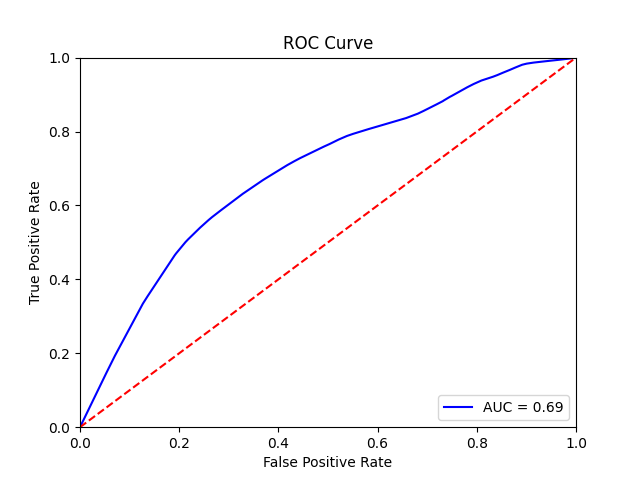

In [15]:
roc_df = evaluationSummary2.roc.toPandas()
plt.close()

plt.plot(roc_df.FPR, roc_df.TPR, 'b', label = 'AUC = %0.2f' % evaluationSummary2.areaUnderROC)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

%matplot plt

In [16]:
print("\nFalse positive rate by label (Training):")
for i, rate in enumerate(evaluationSummary2.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))
print("\nTrue positive rate by label (Training):")
for i, rate in enumerate(evaluationSummary2.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…


False positive rate by label (Training):
label 0: 0.4714433841175984
label 1: 0.23361619608520423

True positive rate by label (Training):
label 0: 0.7663838039147958
label 1: 0.5285566158824017

For Label 0:

False Positive Rate: 47.14%. This means that out of all instances that were actually not label 0, the model incorrectly predicted them as label 0 around 47.14% of the time.
True Positive Rate (also known as Sensitivity or Recall): 76.64%. This means that out of all instances that were actually label 0, the model correctly predicted them as label 0 about 76.64% of the time.
For Label 1:

False Positive Rate: 23.36%. This means that out of all instances that were actually not label 1, the model incorrectly predicted them as label 1 about 23.36% of the time.
True Positive Rate: 52.86%. This means that out of all instances that were actually label 1, the model correctly predicted them as label 1 about 52.86% of the time.
What the model does well:

It has a relatively high true positive rate for Label 0, meaning it does a decent job at correctly identifying instances of this class.
What the model does poorly:

The model has a high false positive rate for Label 0, meaning it often misclassifies instances as belonging to this class when they do not.
The model has a relatively low true positive rate for Label 1, suggesting that it often misses instances of this class.
Ways to improve the model:

To improve the low true positive rate for Label 1, we could explore feature engineering to create more relevant predictors, or try different modeling techniques that may be better suited to your specific problem. We could also tune the model hyperparameters to see if that improves performance. Lastly, it would be worth reviewing the loss function and evaluation metrics to ensure they are correctly incentivizing the model's predictions. For example, we may want to penalize false positives more heavily if they are particularly costly in your application.